In [3]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge,Lasso
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score,roc_curve

warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
df = pd.read_csv('Travel.csv')
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [7]:
df.isnull().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [11]:
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')
df['MaritalStatus'] = df['MaritalStatus'].replace('Single', 'Unmarried')

In [13]:
#Age
df.Age.fillna(df.Age.median(), inplace=True)

#TypeofContract
df.TypeofContact.fillna(df.TypeofContact.mode()[0], inplace=True)

#DurationOfPitch
df.DurationOfPitch.fillna(df.DurationOfPitch.median(), inplace=True)

#NumberOfFollowups
df.NumberOfFollowups.fillna(df.NumberOfFollowups.mode()[0], inplace=True)

#PreferredPropertyStar
df.PreferredPropertyStar.fillna(df.PreferredPropertyStar.mode()[0], inplace=True)

#NumberOfTrips
df.NumberOfTrips.fillna(df.NumberOfTrips.median(), inplace=True)

#NumberOfChildrenVisiting
df.NumberOfChildrenVisiting.fillna(df.NumberOfChildrenVisiting.mode()[0], inplace=True)

#MonthlyIncome
df.MonthlyIncome.fillna(df.MonthlyIncome.median(), inplace=True)

In [15]:
# Customer ID column is not that much needed, so we can drop it.

df.drop(columns='CustomerID', inplace=True, axis=1)
df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Unmarried,1.0,1,2,1,0.0,Manager,20993.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Unmarried,7.0,1,3,0,0.0,Executive,17090.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,0,36.0,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [17]:
# Create a New Column by adding the values of NumberOfPersonVisting and NumberOfChildrenVisiting into one single column

df['TotalVisting'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']
df.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], inplace=True, axis=1)

In [19]:
# Get all the Numerical Features
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print(f"Number of Categorical Features: {len(num_features)}")

# Get all the Categorical Features
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(f"Number of Categorical Features: {len(cat_features)}")

# Get all the discrete features
discrete_features = [feature for feature in num_features if len(df[feature].unique())<=25]
print(f"Number of Discrete Features: {len(discrete_features)}")

# Get all the continuous features

continuous_features = [feature for feature in num_features if feature not in discrete_features]
print(f"Number of Continuous Features: {len(discrete_features)}")

Number of Categorical Features: 12
Number of Categorical Features: 6
Number of Discrete Features: 9
Number of Continuous Features: 9


In [21]:
X = df.drop(columns='ProdTaken', axis=1)
y = df['ProdTaken']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [25]:
# Create column transformer with 2 types of transformers
# The ColumnTransformer is a tool from Scikit-learn that allows you to apply different preprocessing steps to different columns in your dataset.
# It's very useful when you have a mix of Numerical columns (e.g., age, salary) and Categorical columns (e.g., gender, city)




cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
         ("OneHotEncoder", oh_transformer, cat_features),
          ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [27]:
preprocessor

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(),
                                 Index(['TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
       'MaritalStatus', 'Designation'],
      dtype='object')),
                                ('StandardScaler', StandardScaler(),
                                 Index(['Age', 'CityTier', 'DurationOfPitch', 'NumberOfFollowups',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome', 'TotalVisting'],
      dtype='object'))])

In [29]:
# Applying Transformation in Training Data
X_train = preprocessor.fit_transform(X_train)

# Applying Transformation in Test Data
X_test = preprocessor.transform(X_test)

## Applying XGboost Classifier along with other ML Algorithms

In [32]:
# Apply AdaBoost Algorithm

models={
    "Logisitic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Gradient Boost":GradientBoostingClassifier(),
    "Ada Boost":AdaBoostClassifier(),
    "XGBoost":XGBClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

Logisitic Regression
Model performance for Training set
- Accuracy: 0.8409
- F1 score: 0.8138
- Precision: 0.6879
- Recall: 0.2919
- Roc Auc Score: 0.6305
----------------------------------
Model performance for Test set
- Accuracy: 0.8517
- F1 score: 0.8272
- Precision: 0.7215
- Recall: 0.3167
- Roc Auc Score: 0.6445


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8967
- F1 score: 0.8985
- Precision: 0.7005
- Recall: 0.7667
- Roc Auc Score: 0.8464


Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9192
- F1 score: 0.9119
- Precision: 0.9391
- Recall: 0.6000
- Roc Auc Score: 0.7956


Gradient Boost
Model performance for Training se

In [34]:
# Hyperparameter Tuning

xg_params = {'learning_rate': [0.1, 0.01],
             'max_depth': [5, 8, 12, 20, 30],
             'n_estimators': [100, 200, 300],
             'colsample_bytree': [0.5, 0.8, 1, 0.3, 0.4]}

In [36]:
xg_params

{'learning_rate': [0.1, 0.01],
 'max_depth': [5, 8, 12, 20, 30],
 'n_estimators': [100, 200, 300],
 'colsample_bytree': [0.5, 0.8, 1, 0.3, 0.4]}

In [38]:
# Models list for Hyperparameter Tuning

randomcv_models = [
                   ("XGBoost", XGBClassifier(), xg_params)
                   
                   ]

In [40]:
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for XGBoost -------------------
{'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [46]:
models={
    "XGBoost Classifier": XGBClassifier(n_estimators=300, max_depth=30, learning_rate=0.1, colsample_bytree=0.8)
}
for key, value in models.items():
    model = value
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(key)
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

XGBoost Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9458
- F1 score: 0.9435
- Precision: 0.9379
- Recall: 0.7556
- Roc Auc Score: 0.8721




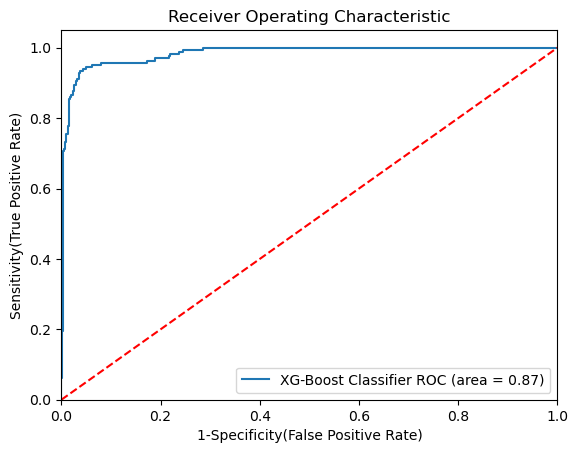

In [48]:
## Plot ROC AUC Curve
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'XG-Boost Classifier',
    'model': XGBClassifier(n_estimators=300, max_depth=30, learning_rate=0.1, colsample_bytree=0.8),
    'auc':  0.8721
},
    
]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("auc.png")
plt.show()

## Application of XGBoost Regressor along with other ML Algorithms

In [81]:
df = pd.read_csv('cardekho_imputated.csv', index_col=[0])
df.head()

,car_name,brand,model,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
0,Maruti Alto,Maruti,Alto,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,120000
1,Hyundai Grand,Hyundai,Grand,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,550000
2,Hyundai i20,Hyundai,i20,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,215000
3,Maruti Alto,Maruti,Alto,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,226000
4,Ford Ecosport,Ford,Ecosport,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,570000


In [83]:
# We don't require the car_name, brand columns. Hence, we remove them.

df.drop(columns=['car_name', 'brand'], axis=1, inplace=True)

In [85]:
df['model'].unique()

array(['Alto', 'Grand', 'i20', 'Ecosport', 'Wagon R', 'i10', 'Venue',
       'Swift', 'Verna', 'Duster', 'Cooper', 'Ciaz', 'C-Class', 'Innova',
       'Baleno', 'Swift Dzire', 'Vento', 'Creta', 'City', 'Bolero',
       'Fortuner', 'KWID', 'Amaze', 'Santro', 'XUV500', 'KUV100', 'Ignis',
       'RediGO', 'Scorpio', 'Marazzo', 'Aspire', 'Figo', 'Vitara',
       'Tiago', 'Polo', 'Seltos', 'Celerio', 'GO', '5', 'CR-V',
       'Endeavour', 'KUV', 'Jazz', '3', 'A4', 'Tigor', 'Ertiga', 'Safari',
       'Thar', 'Hexa', 'Rover', 'Eeco', 'A6', 'E-Class', 'Q7', 'Z4', '6',
       'XF', 'X5', 'Hector', 'Civic', 'D-Max', 'Cayenne', 'X1', 'Rapid',
       'Freestyle', 'Superb', 'Nexon', 'XUV300', 'Dzire VXI', 'S90',
       'WR-V', 'XL6', 'Triber', 'ES', 'Wrangler', 'Camry', 'Elantra',
       'Yaris', 'GL-Class', '7', 'S-Presso', 'Dzire LXI', 'Aura', 'XC',
       'Ghibli', 'Continental', 'CR', 'Kicks', 'S-Class', 'Tucson',
       'Harrier', 'X3', 'Octavia', 'Compass', 'CLS', 'redi-GO', 'Glanza',
       

In [87]:
# Numerical Features
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print(f"Number of Categorical Features: {len(num_features)}")

# Categorical Features
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(f"Number of Categorical Features: {len(cat_features)}")

# Discrete Features
discrete_features = [feature for feature in num_features if len(df[feature].unique())<=25]
print(f"Number of Discrete Features: {len(discrete_features)}")

# Continuous Features
continuous_features = [feature for feature in num_features if feature not in discrete_features]
print(f"Number of Continuous Features: {len(discrete_features)}")

Number of Categorical Features: 7
Number of Categorical Features: 4
Number of Discrete Features: 2
Number of Continuous Features: 2


In [89]:
# Independent and Dependent Features

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [91]:
# We will use Label Encoder for Model column in the datset as the number of unique values are very high.

le = LabelEncoder()
X['model'] = le.fit_transform(X['model'])

In [93]:
len(df['seller_type'].unique()), len(df['fuel_type'].unique()), len(df['transmission_type'].unique())

(3, 5, 2)

In [95]:
# Create Column Transformer with 2 types of transformers

num_features = X.select_dtypes(exclude='object').columns           # Numerical Features
cat_features = X.select_dtypes(include='object').columns           # Categorical Features

num_transformer = StandardScaler()

# We use One-Hot Encoder for the other Categorical features as the number of values are less.
oh_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    [
         ("OneHotEncoder", oh_transformer, cat_features),
          ("StandardScaler", num_transformer, num_features)
    ], remainder='passthrough'
)

In [97]:
X = preprocessor.fit_transform(X)

In [99]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
##Create a Function to Evaluate Model
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [105]:
# Beginning Model Training
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Adaboost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "XGBooost": XGBRegressor()
}

for key, value in models.items():
    model = value
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(key)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 553855.6665
- Mean Absolute Error: 268101.6071
- R2 Score: 0.6218
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 502543.5930
- Mean Absolute Error: 279618.5794
- R2 Score: 0.6645


Lasso
Model performance for Training set
- Root Mean Squared Error: 553855.6710
- Mean Absolute Error: 268099.2226
- R2 Score: 0.6218
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 502542.6696
- Mean Absolute Error: 279614.7461
- R2 Score: 0.6645


Ridge
Model performance for Training set
- Root Mean Squared Error: 553856.3160
- Mean Absolute Error: 268059.8015
- R2 Score: 0.6218
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 502533.8230
- Mean Absolute Error: 279557.2169
- R2 Score: 0.6645


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 325873.0088
- Mean 

In [107]:
# Hyperparameter Tuning

xg_params = {'learning_rate': [0.1, 0.01],
             'max_depth': [5, 8, 12, 20, 30],
             'n_estimators': [100, 200, 300],
             'colsample_bytree': [0.5, 0.8, 1, 0.3, 0.4]}

In [109]:
# Models list for Hyperparameter tuning
randomcv_models = [("XGBoost", XGBRegressor(), xg_params)]

In [111]:
randomcv_models

[('XGBoost',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, ...),
  {'learning_rate': [0.1, 0.01],
   'max_depth': [5, 8, 12, 20, 30],
   'n_estimators': [100, 200, 300],
   'colsample_bytree': [0.5, 0.8, 1, 0.3, 0.4]})]

In [113]:
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for XGBoost -------------------
{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [115]:
## Retraining the models with best parameters
models = {
    "XGBoost Regressor": XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, colsample_bytree=0.8)
    
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

XGBoost Regressor
Model performance for Training set
- Root Mean Squared Error: 107872.7065
- Mean Absolute Error: 71943.1849
- R2 Score: 0.9857
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 282987.1247
- Mean Absolute Error: 101325.8009
- R2 Score: 0.8936


